In [1]:
import os
import math
import random
import numpy as np
import itertools
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import KATNetwork

In [2]:
num_train_packs = 100000
num_in_channels = 25
num_out_channels = 4
num_test_packs = 10000
thr = 0.04

in_train_data = torch.zeros((num_train_packs, num_in_channels), dtype=torch.float32)
out_train_data = torch.zeros((num_train_packs, num_out_channels), dtype=torch.float32)
in_test_data = torch.zeros((num_test_packs, num_in_channels), dtype=torch.float32)
out_test_data = torch.zeros((num_test_packs, num_out_channels), dtype=torch.float32)

def generate_mu(num_particles, thr):
    while True:
        mu = [random.uniform(0.2, 0.8) for _ in range(num_particles)]
        if all(abs(a - b) > thr for a, b in itertools.combinations(mu, 2)):
            return mu

for i in range(num_train_packs):
    num_particles = random.randint(1, num_out_channels)
    mu = generate_mu(num_particles, thr)
    sigma = [random.uniform(0.04, 0.065) for _ in range(num_particles)]
    amp = [random.uniform(0.3, 1.0) for _ in range(num_particles)]
    
    for l in range(num_in_channels):
        sum_val = sum(
            amp[j]
            * math.exp(
                -((l / (num_in_channels - 1) - mu[j]) ** 2)
                / (2 * sigma[j] ** 2)
            )
            for j in range(num_particles)
        )
        in_train_data[i, l] = sum_val
    
    mu.sort()
    while len(mu) < num_out_channels:
        mu.append(0.9)
    
    for j in range(num_out_channels):
        out_train_data[i, j] = mu[j]

for i in range(num_test_packs):
    num_particles = random.randint(1, num_out_channels)
    mu = generate_mu(num_particles, thr)
    sigma = [random.uniform(0.04, 0.065) for _ in range(num_particles)]
    amp = [random.uniform(0.3, 1.0) for _ in range(num_particles)]
    
    for l in range(num_in_channels):
        sum_val = sum(
            amp[j]
            * math.exp(
                -((l / (num_in_channels - 1) - mu[j]) ** 2)
                / (2 * sigma[j] ** 2)
            )
            for j in range(num_particles)
        )
        in_test_data[i, l] = sum_val
    
    mu.sort()
    while len(mu) < num_out_channels:
        mu.append(0.9)
    
    for j in range(num_out_channels):
        out_test_data[i, j] = mu[j]


In [3]:
train_dataset = TensorDataset(in_train_data, out_train_data)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(in_test_data, out_test_data)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device, "device")

Using cuda device


In [6]:
def rms_loss(pred, target):
    loss = (pred - target) ** 2
    return torch.sqrt(loss.mean())

def loss(pred, target, weights, sigmas, gamma=0.0001):
    loss = (pred - target) ** 2

    reg = []
    for i in range(len(weights)):
        r = torch.abs(weights[i] / sigmas[i])
        reg.append(r.sum())

    return torch.sqrt(loss.mean()) + gamma * torch.stack(reg).sum()

In [ ]:
model = KATNetwork.KATMLP(num_in_channels, [(2*num_in_channels+1)*num_out_channels], num_out_channels, [(0, 4), (-1, 1)], 20).to(device) 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)
""" optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,              
    max_iter=50,
    max_eval=50,       
    history_size=200,
    line_search_fn='strong_wolfe'
) """

In [ ]:
criterion = loss
num_epochs = 30

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
        model.train()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets, 
                            [model.model[i].w for i in range(len(model.model))], 
                            [model.model[i].sigma for i in range(len(model.model))])

            loss.backward()

            optimizer.step()

            """ def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets, 
                                [model.model[i].w for i in range(len(model.model))], 
                                [model.model[i].sigma for i in range(len(model.model))])

                loss.backward()

                return loss

            optimizer.step(closure) """

        model.eval()
        train_loss = 0.0
        test_loss = 0.0

        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                loss = rms_loss(outputs, targets)

                train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                loss = rms_loss(outputs, targets)

                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5e}, Test Loss: {test_loss:.5e}")

In [9]:
output_dir = '../resolution_model/'

model_save_path = os.path.join(output_dir, f'adamw_p_{num_in_channels}_model_checkpoint.pth')

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

if os.path.exists(model_save_path):
    os.remove(model_save_path)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, model_save_path)
print('Model saved')

Model saved


In [ ]:
model_save_path = '../resolution_model/model_checkpoint.pth'

if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, weights_only=True, map_location=device)
    if 'model_state_dict' in checkpoint and 'optimizer_state_dict' in checkpoint and 'epoch' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f'Loaded checkpoint from epoch {checkpoint['epoch'] + 1}')
    else:
        print('Checkpoint file is missing some keys, starting from scratch.')

Loaded checkpoint from epoch 20


In [8]:
xlist = np.linspace(-1, 5, 1000).tolist()

ylist = [model.model[0].eval_func(x, 0, 0) for x in xlist]

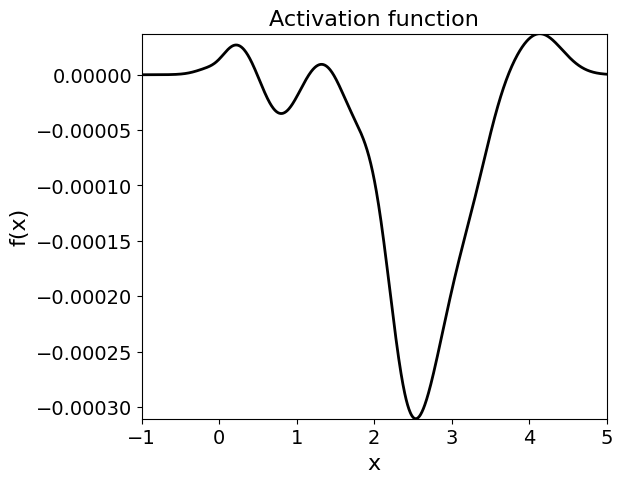

In [9]:
plt.figure(figsize=(6, 5))
plt.plot(xlist, ylist, color='black', linestyle='-', linewidth=2)
plt.xlabel("x", fontsize=16)
plt.ylabel("f(x)", fontsize=16)
plt.title("Activation function", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-1, 5)
plt.ylim(min(ylist), max(ylist))
plt.show()

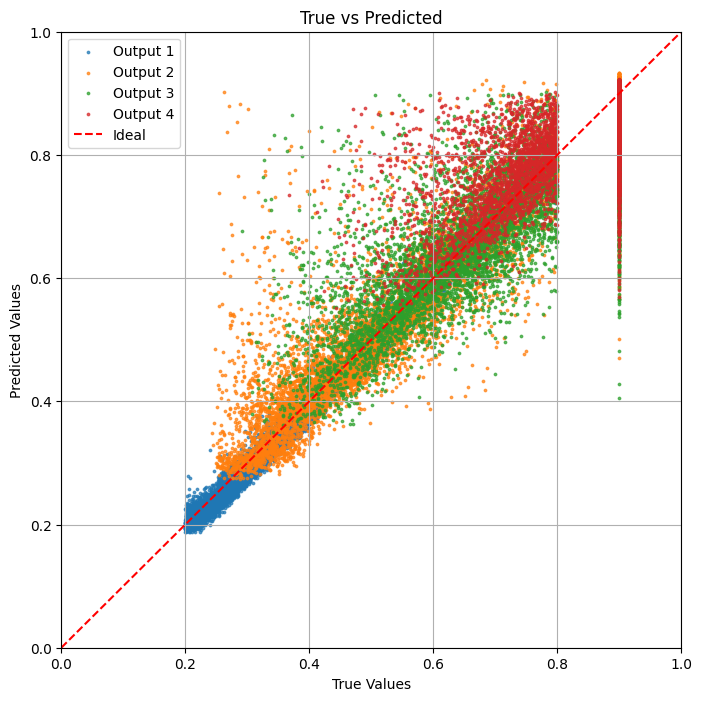

In [13]:
model.eval()

true_values = []
pred_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        true_values.append(targets.cpu())
        pred_values.append(outputs.cpu())

true_values = torch.cat(true_values, dim=0)
pred_values = torch.cat(pred_values, dim=0)

plt.figure(figsize=(8, 8))
for i in range(true_values.size(1)):
    plt.scatter(true_values[:, i], pred_values[:, i], label=f'Output {i + 1}', s=3, alpha=0.7)

plt.plot([0, 3], [0, 3], 'r--', label='Ideal')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
with open(f'../results/adamw_p_{num_in_channels}_results.txt', mode='w') as file:
    for i in range(true_values.size(0)):
        for j in range(true_values.size(1)):
            file.write(f'{i}\t{true_values[i, j].item()}\t{pred_values[i, j].item()}\n')

print("Results are saved in 'results.txt'.")


Results are saved in 'results.txt'.


In [ ]:
print(train_loss_list)
print(test_loss_list)

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, len(train_loss_list)+1)], train_loss_list, color='black', linestyle='-', linewidth=2)
plt.plot([i for i in range(1, len(test_loss_list)+1)], test_loss_list, color='red', linestyle='-', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("RMS")
plt.title("True vs Predicted")
plt.xlim(0, 1.05 * len(train_loss_list))
plt.ylim(5e-2, 7e-2)
plt.show()